# Training

* Code by Caroline Juang, c.juang@columbia.edu
* With help from Mark Goldstein (NYU) and Jianing Fang (Columbia EAEE)
* For Machine Learning for the Environmental Sciences, Columbia University
* Professor: Pierre Gentine
* November 2021 - December 2021

### Data source

The data has already been downloaded and preprocessed for use in the `Preprocessing` notebook.

For your record, the data were created by Park Williams, from various sources. [Download from Box](https://ucla.app.box.com/s/epgbcn89365loer1dbp2gz21lc75uut9/folder/136851087076)

Fire data is created by Caroline Juang and Park Williams, from the Monitoring Trends in Burn Severity (MTBS) product and government agency databases. Use the `burnarea_combined.nc` file. [Download from Box](https://ucla.app.box.com/s/epgbcn89365loer1dbp2gz21lc75uut9/folder/136850119129)

**Variables Used**

Just for technical use
* EPA ecoregion `epa_l2`
* western US region `mask_US`

Variable to predict
* forest burned area `burnarea`

Static
* fractional forest area `forest`
* elevation `elev`

Land cover change
* Distance to wildland-urban interface `wui_distance_new`
* Months since gridcell burned `return_months`
* Years since gridcell burned `return_years`

Climate (and z-variables which represent `observed` - `1984-2019 average`)
* daily maximum temperature `Tmax` `Tmax_z`
* vapor-pressure deficit `vpd` `vpd_z`
* relative humidity `rh` `rh_z`
* precipitation `prec` `prec_z`
* wind `wind`

### Ecoregions
* 10.1 Cold deserts
* 7.1 Marine west coast forest
* 11.1 Mediterranean California
* 9.4 South Central Semiarid Prairies
* 9.2 Temperate Prairies (not included)
* 13.1 Upper Gila Mountains
* 10.2 Warm Deserts
* 9.3 West-Central Semiarid Prairies
* 6.2 Western Cordillera
* 12.1 Western Sierra Madre Piedmont

### Workspace Setup

In [1]:
# import
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

### Import data created using `Preprocessing`

In [2]:
# import preprocessed datasets

epa_l2 = xr.open_dataset('data\\epa_l2.nc') # static
maskUS = xr.open_dataset('data\\maskUS.nc')
forest = xr.open_dataset('data\\forest.nc')
elevstd = xr.open_dataset('data\\elevstd.nc')

vpd = xr.open_dataset('data\\vpd.nc') # climate
rh = xr.open_dataset('data\\rh.nc')
tmax = xr.open_dataset('data\\tmax.nc')
prec = xr.open_dataset('data\\prec.nc')
wind = xr.open_dataset('data\\wind.nc')
vpd_z = xr.open_dataset('data\\vpd_z.nc')
rh_z = xr.open_dataset('data\\rh_z.nc')
tmax_z = xr.open_dataset('data\\tmax_z.nc')
prec_z = xr.open_dataset('data\\prec_z.nc')

burnarea = xr.open_dataset('data\\burnarea.nc') # y variable to predict
wui_distance_new = xr.open_dataset('data\\wui_distance_new.nc') # land change
return_years = xr.open_dataset('data\\return_years.nc')
return_months = xr.open_dataset('data\\return_months.nc')

In [3]:
# format variables
time = burnarea.time
elevstd_new = elevstd.expand_dims({'time':time}) # expand to include monthly data (static variable)
elevstd_new = elevstd_new.elevstd

# get only forested areas
mask = forest>0.50

#vpd = vpd.where(mask)
#rh = rh.where(mask)
#tmax = tmax.where(mask)
#prec = prec.where(mask)
#wind = wind.where(mask)
#vpd_z = vpd_z.where(mask)
#rh_z = rh_z.where(mask)
#tmax_z = tmax_z.where(mask)
#prec_z = prec_z.where(mask)
#burnarea = burnarea.where(mask)
#wui_distance_new = wui_distance_new.where(mask)
#return_years = return_years.where(mask)
#return_months = return_months.where(mask)
#elevstd_new = elevstd_new.where(mask)

In [4]:
# transform xarray dataarrays to numpy arrays

elev_np = elevstd_new.values
vpd_np = vpd.__xarray_dataarray_variable__.values
rh_np = rh.rh.values
tmax_np = tmax.tmax.values
prec_np = prec.prec.values
wind_np = wind.wind.values #
vpdz_np = vpd_z.__xarray_dataarray_variable__.values #
rhz_np = rh_z.__xarray_dataarray_variable__.values 
tmaxz_np = tmax_z.__xarray_dataarray_variable__.values #
burn_np = burnarea.burnarea.values #
wui_np = wui_distance_new.wui_distance.values
returnm_np = return_months.__xarray_dataarray_variable__.values #

### Use numpy arrays and preprocess for the model

We are following the ConvLSTM keras tutorial here: https://keras.io/examples/vision/conv_lstm/

In [5]:
# import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [6]:
# load the variables
feature1 = burn_np
feature2 = wind_np
feature3 = vpdz_np
feature4 = tmaxz_np
feature5 = returnm_np

# we trim the dataset to make it easily divisible
# we swap the dimensions to fit 
def trim(x):
    # make divisible by 10 to make separate datapoints later
    return x[:,:200,:150]
def swap(x):
    # swap time dim to end
    return np.swapaxes(x, 0, 2)

# note burned_area is channel 1
# important for defining target later
feature1 = swap(trim(feature1))
feature2 = swap(trim(feature2))
feature3 = swap(trim(feature3))
feature4 = swap(trim(feature4))
feature5 = swap(trim(feature5))

# first channel is burned area
dataset = np.stack([feature1,
                    feature2,
                    feature3,
                    feature4,
                    feature5])
print(dataset.shape)
# change dataset from (channels,dim1,dim2,time)
# to (time,dim1,dim2,channels)
dataset = np.transpose(dataset,(3,1,2,0))
print(dataset.shape)

(5, 150, 200, 432)
(432, 150, 200, 5)


In [7]:
# break spatial data into (blocksize,blocksize) blocks
new_data = []
blocksize = 10
dim1=dataset.shape[1]
dim2=dataset.shape[2]
# the below code will change dataset 
# from (timesteps, dim1, dim2, channels)
# to (datapoints, timesteps, blocksize, blocksize, channels)
for i in range(int(dim1/blocksize)):
    x_start = i*blocksize
    x_end = x_start + blocksize
    for j in range(int(dim2/blocksize)):
        y_start = j*blocksize
        y_end = y_start+blocksize
        datapoint = dataset[:,x_start:x_end,y_start:y_end,:]
        new_data.append(datapoint)
dataset_10 = np.stack(new_data)
#print(dataset_10.shape)

### Split dataset into training and validation

In [9]:
# split into train and test.
# for now, train on earlier data, test on later data
# def train by first 232 of 432 timesteps.
# 232 not so important but good to keep train/test sequences
# similar length
# later... you may choose to not split train/test by time.
train_dataset = dataset_10[:,:232,:,:,:]
test_dataset = dataset_10[:,232:,:,:,:]
print(train_dataset.shape)
print(test_dataset.shape)

(300, 232, 10, 10, 5)
(300, 200, 10, 10, 5)


In [10]:
# splits things into (input,output)
def make_input_output(dataset):
    # dataset is (N,time,dim1,dim2,channels)
    timesteps = dataset.shape[1]
    burned_area_channel = 0
    # two things are done here
    # first, shift targets y by one timestep from x as in demo
    # second, only burned area channel used for outputs
    x = dataset[:, 0 : timesteps - 1, :,:,:]
    y = dataset[:, 1 : timesteps    , :,:,burned_area_channel]
    
    # finally, here is where you might want to binarize y
    # for yes/no predictions rather than how much burned.
    y = (y>0).astype(int)
    return x,y

x_train,y_train = make_input_output(train_dataset)
x_val,y_val = make_input_output(test_dataset)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
# notice that num timesteps is reduced by 1
# because we have nothing to predict from
# the last timestep

(300, 231, 10, 10, 5)
(300, 231, 10, 10)
(300, 199, 10, 10, 5)
(300, 199, 10, 10)


### Construct the model

In [11]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=8,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

# assuming binary targets here, but see below for another option
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)
# for predicting how much will burn rather than yes/no
# you would have to
# (1) change sigmoid to relu in the last layer
# (2) change loss to  loss=keras.losses.MeanSquaredError

In [12]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
60/60 [==============================] - ETA: 0s - loss: nan

KeyboardInterrupt: 

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

# Initial investigations

In [10]:
# import
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# using code from https://machinelearningmastery.com/random-forest-ensemble-in-python/

In [ ]:
# test classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
# summarize the dataset
print(X.shape, y.shape)

### Import Dependencies

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from Seq2Seq import Seq2Seq
from torch.utils.data import DataLoader

import io
import imageio
from ipywidgets import widgets, HBox
import matplotlib.pyplot as plt
from ConvLSTM import ConvLSTM
from tqdm.notebook import tqdm
entire_sequence_version=True



# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Import Data and Create Dataloaders

In [4]:
# Load Data as Numpy Array
MovingMNIST = np.load('mnist_test_seq.npy').transpose(1, 0, 2, 3)

# Shuffle Data
np.random.shuffle(MovingMNIST)

# Train, Test, Validation splits
train_data = MovingMNIST[:8000]         
val_data = MovingMNIST[8000:9000]       
test_data = MovingMNIST[9000:10000]     

def collate3d(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # the output is the input sequence shift right by 1, both have length 19
    rand = np.random.randint(10,20)
    seq_len=batch.shape[2]
    return batch[:,:,0:seq_len-1], batch[:,:,1:seq_len]      

def collate2d(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,20)                     
    return batch[:,:,rand-10:rand], batch[:,:,rand]

if entire_sequence_version:
    # Training Data Loader
    train_loader = DataLoader(train_data, shuffle=True, 
                            batch_size=16, collate_fn=collate3d)

    # Validation Data Loader
    val_loader = DataLoader(val_data, shuffle=True, 
                            batch_size=16, collate_fn=collate3d)
else:
    # Training Data Loader
    train_loader = DataLoader(train_data, shuffle=True, 
                            batch_size=16, collate_fn=collate2d)

    # Validation Data Loader
    val_loader = DataLoader(val_data, shuffle=True, 
                            batch_size=16, collate_fn=collate2d)

### Visualize Data

In [5]:
# Get a batch
input, _ = next(iter(val_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     

for video in input.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

### Instantiate Model, Optimizer and Loss

In [6]:
# The input video frames are grayscale, thus single channel
if entire_sequence_version:
    model = Seq2Seq(num_channels=1, num_kernels=64, 
    kernel_size=(3, 3), padding=(1, 1), activation="relu", 
    frame_size=(64, 64), num_layers=3, return_sequences=True).to(device)
else:
    model = Seq2Seq(num_channels=1, num_kernels=64, 
    kernel_size=(3, 3), padding=(1, 1), activation="relu", 
    frame_size=(64, 64), num_layers=3, return_sequences=False).to(device)
    

optim = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')

### Train for about 20 epochs

In [ ]:
num_epochs = 20

for epoch in range(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()                                                  
    for batch_num, (input, target) in enumerate(tqdm(train_loader)):
        output = model(input)                                     
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()                                 
    train_loss /= len(train_loader.dataset)                       

    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(val_loader.dataset)                            

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))


Epoch:1 Training Loss:2236.41 Validation Loss:2138.27




Epoch:2 Training Loss:2093.28 Validation Loss:2056.14



### Visualize what our model has learned so far

In [9]:
### for 3d evaluation only 
if entire_sequence_version:
    def collate_test(batch):

        # Last 10 frames are target
        target = np.array(batch)[:,10:]                     

        # Add channel dim, scale pixels between 0 and 1, send to GPU
        batch = torch.tensor(batch).unsqueeze(1)          
        batch = batch / 255.0                             
        batch = batch.to(device)                          
        return batch, target

    # Test Data Loader
    test_loader = DataLoader(test_data,shuffle=True, 
                             batch_size=3, collate_fn=collate_test)

    # Get a batch
    batch, target = next(iter(test_loader))

    # Initialize output sequence
    output = np.zeros(target.shape, dtype=np.uint8)

    # Loop over timesteps
    for timestep in range(target.shape[1]):
      input = batch[:,:,timestep:timestep+10]   
      output[:,timestep]=(model(input).squeeze(1).cpu()[:,-1]>0.5)*255.0

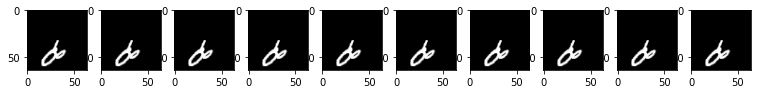

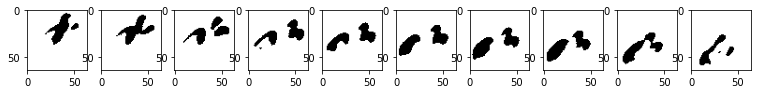

In [52]:
### for 3D evaluation only
if entire_sequence_version:
    seq_len=input.squeeze(1)[0].shape[0]
    fig, axs=plt.subplots(1,10, figsize=(13,1.1))
    ax=axs.flatten()
    for i in range(seq_len):
        ax[i].imshow(input.squeeze(1)[0][1].cpu().numpy() * 255, cmap='gray', vmin=0, vmax=255)

    seq_len=output[0].shape[0]
    fig, axs=plt.subplots(1,10, figsize=(13,1.1))
    ax=axs.flatten()
    for i in range(seq_len):
        ax[i].imshow(output[0][i], cmap='gray', vmin=0, vmax=255)

In [ ]:
### for 2d evaluation
if not entire_sequence_version:
    def collate_test(batch):

        # Last 10 frames are target
        target = np.array(batch)[:,10:]                     

        # Add channel dim, scale pixels between 0 and 1, send to GPU
        batch = torch.tensor(batch).unsqueeze(1)          
        batch = batch / 255.0                             
        batch = batch.to(device)                          
        return batch, target

    # Test Data Loader
    test_loader = DataLoader(test_data,shuffle=True, 
                             batch_size=3, collate_fn=collate_test)

    # Get a batch
    batch, target = next(iter(test_loader))

    # Initialize output sequence
    output = np.zeros(target.shape, dtype=np.uint8)

    # Loop over timesteps
    for timestep in range(target.shape[1]):
      input = batch[:,:,timestep:timestep+10]   
      output[:,timestep]=(model(input).squeeze(1).cpu()>0.5)*255.0

In [10]:
### for 2d evaluation
if not entire_sequence_version:
    for tgt, out in zip(target, output):       # Loop over samples

        # Write target video as gif
        with io.BytesIO() as gif:
            imageio.mimsave(gif, tgt, "GIF", fps = 5)    
            target_gif = gif.getvalue()

        # Write output video as gif
        with io.BytesIO() as gif:
            imageio.mimsave(gif, out, "GIF", fps = 5)    
            output_gif = gif.getvalue()

        display(HBox([widgets.Image(value=target_gif), 
                      widgets.Image(value=output_gif)]))